<a href="https://colab.research.google.com/github/fkhafizov/w2v/blob/main/w2v_tf_fast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# w2v_tf_fast
# 2021.02.28

import numpy as np
import pandas as pd
pd.options.display.max_columns = 500
pd.set_option('display.width', 1000)
import matplotlib.pyplot as plt
from keras import models
from keras import layers 
import tensorflow as tf
from tensorflow.keras.utils import plot_model
import time
import re   # p = re.split(r'(?<=[^A-Z].[.?]) +(?=[A-Z])', p)

def get_padding(x):
  return (np.max(x)-np.min(x))/20

def plot_words(w2v_df, ttl):
  # plot words according to their embedding
  x1 = np.array(w2v_df['x1'])
  x2 = np.array(w2v_df['x2'])
  # wrd = 
  x_axis_min, x_axis_max = np.min(x1)-get_padding(x1), np.max(x1)+get_padding(x1)
  y_axis_min, y_axis_max = np.min(x2)-get_padding(x2), np.max(x2)+get_padding(x2)

  plt.close()
  fig, ax = plt.subplots()
  plt.rcParams["figure.figsize"] = (10,10)
  # plt.figure(figsize=(10,10))

  plt.scatter(x1, x2, c='red', s=500, alpha=0.3)
  # plt.text(x1+.03, x2+.03, np.asarray(w2v_df['word']), fontsize=9)
  for word, x1, x2 in zip(w2v_df['word'], w2v_df['x1'], w2v_df['x2']):
    if word != 'кичлам':
      ax.annotate(word, (x1,x2 ), fontsize=14, color='blue')
      
  ix  =  w2v_df['word']=='кичлам'
  [_,w,wx1,wx2] = np.asarray(w2v_df.loc[ix])[0]
  ax.annotate(w, (wx1,wx2 ), fontsize=16, color='red')

  plt.xlim(x_axis_min,x_axis_max)
  plt.ylim(y_axis_min,y_axis_max)
  plt.title(ttl, fontsize=18)
  plt.show()

text = "Балерина вдохновляет девочку. КИЧЛАМ сильный и ловкий. Штангист сильный мужчина. Балерина красивая женщина. Юниор ловкий штангист. \
Юниор молодой мужчина. Девочку учит балерина. "

corpus = [s.lower().replace('- ','').replace(',','').strip() for s in re.split(r'(?<=[^A-Z].[.?]) +(?=[A-Z])', text)[0].split('.')[:-1] ]
# corpus

def remove_stop_words(corpus):
    stop_words = ['is', 'a', 'will', 'be', 'и', 'он', 'этот', 'она']
    results = []
    for text in corpus:
        tmp = text.split(' ')
        for stop_word in stop_words:
            if stop_word in tmp:
                tmp.remove(stop_word)
        results.append(" ".join(tmp))
    return results

corpus = remove_stop_words(corpus)
corpus

['балерина вдохновляет девочку',
 'кичлам сильный ловкий',
 'штангист сильный мужчина',
 'балерина красивая женщина',
 'юниор ловкий штангист',
 'юниор молодой мужчина',
 'девочку учит балерина']

In [2]:
sentences = [s.split(' ') for s in corpus]

vocab=[]
for ss in sentences:
  vocab += ss
vocab = sorted(set(vocab))

word2int = {}
for i,word in enumerate(vocab):
    word2int[word] = i
# print('word2int=', word2int)

WINDOW_SIZE = 2
data = []
for sentence in sentences:
    for idx, word in enumerate(sentence):
        for neighbor in sentence[max(idx - WINDOW_SIZE, 0) : min(idx + WINDOW_SIZE, len(sentence)) + 1] : 
            if neighbor != word:
                data.append([word, neighbor])
df = pd.DataFrame(data, columns = ['input', 'label'])

print(f'{len(vocab)} слов; СЛОВАРЬ=', vocab)
print( f'Pазмер окна = {WINDOW_SIZE}, {len(df)} контекстные пары слов')
print(sentences)
df.head()
# df.head(n=len(df))

w2idx = pd.DataFrame.from_dict({ 'values': word2int.values(), 'word': word2int.keys() })
# print(w2idx.head())


ONE_HOT_DIM = len(vocab)
def to_one_hot_encoding(data_point_index):
    one_hot_encoding = np.zeros(ONE_HOT_DIM)
    one_hot_encoding[data_point_index] = 1
    return one_hot_encoding

X = [] # input word
Y = [] # target word
for x, y in zip(df['input'], df['label']):
    X.append(to_one_hot_encoding(word2int[ x ]))
    Y.append(to_one_hot_encoding(word2int[ y ]))

X_train = np.asarray(X)
Y_train = np.asarray(Y)
df['X_train']=list(X_train)
df['Y_train']=list(Y_train)
# df.head()
dfint = df.copy()
dfint['X_train']=list(X_train.astype(int))
dfint['Y_train']=list(Y_train.astype(int))
dfint.head()

13 слов; СЛОВАРЬ= ['балерина', 'вдохновляет', 'девочку', 'женщина', 'кичлам', 'красивая', 'ловкий', 'молодой', 'мужчина', 'сильный', 'учит', 'штангист', 'юниор']
Pазмер окна = 2, 42 контекстные пары слов
[['балерина', 'вдохновляет', 'девочку'], ['кичлам', 'сильный', 'ловкий'], ['штангист', 'сильный', 'мужчина'], ['балерина', 'красивая', 'женщина'], ['юниор', 'ловкий', 'штангист'], ['юниор', 'молодой', 'мужчина'], ['девочку', 'учит', 'балерина']]


,input,label,X_train,Y_train
0,балерина,вдохновляет,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1,балерина,девочку,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
2,вдохновляет,балерина,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
3,вдохновляет,девочку,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
4,девочку,балерина,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


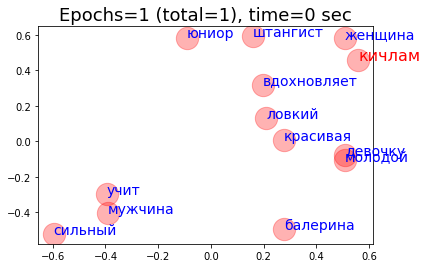

In [3]:
model = models.Sequential()
# https://www.tensorflow.org/api_docs/python/tf/keras/activations   # network.add( layers.Dense(2, activation='relu', input_shape=(12,) ) )
model.add( layers.Dense(2, activation='linear', input_shape=(ONE_HOT_DIM,) ) )
model.add( layers.Dense(ONE_HOT_DIM, activation='softmax' ) )
model.compile( optimizer='rmsprop', 
                 loss = 'categorical_crossentropy', 
                 metrics = ['accuracy'] )
plot_model(model, show_shapes=1, show_dtype=0,show_layer_names=0)              # plot_model(model, show_shapes=1, show_layer_names=1)

%matplotlib inline
# EPOCHS = 100
total_epochs = 0

def model_fit_n_show(model, eps=10):
  global total_epochs
  sttime = time.time()
  model.fit( X_train, Y_train, epochs=eps, batch_size=1, verbose=0)
  d2 = pd.DataFrame(  model.weights[0].numpy(),  columns = ['x1', 'x2'] )
  w2v_df = pd.concat( [w2idx,d2],axis=1 )
  # ?network.fit
  endtime = time.time()
  total_epochs += eps 
  ttl = f'Epochs={eps} (total={total_epochs}), time={int(endtime-sttime)} sec'
  # print(ttl)
  plot_words(w2v_df, ttl)
  return model, w2v_df, total_epochs

model, w2v_df, total_epochs = model_fit_n_show(model,eps=1)

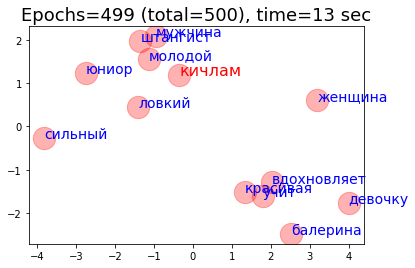

In [4]:
%matplotlib inline
model, w2v_df, total_epochs = model_fit_n_show(model,eps=499)